In [129]:
#importing all the necessart packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from collections import OrderedDict

#isgnoring the warning
import warnings
warnings.filterwarnings('ignore')



# Function for Features and Smoothing

In [130]:
# Function to produce Features and to smooth prices of stock

def RSI(dataframe, period, column_name):
    '''
    Computes the RSI of a given price series for a given period length
    :param dataframe:
    :param period:
    :return dataframe with rsi:
    '''

    rsi = []


    diff = np.diff(dataframe[column_name]) # length is 1 less than the all_prices
    for i in range(period):
        rsi.append(None) # because RSI can't be calculated until period prices have occured

    for i in range(len(diff) - period + 1):
        avg_gain = diff[i:period + i]
        avg_loss = diff[i:period + i]
        avg_gain = abs(sum(avg_gain[avg_gain >= 0]) / period)
        avg_loss = abs(sum(avg_loss[avg_loss < 0]) / period)
        if avg_loss == 0:
            rsi.append(100)
        elif avg_gain == 0:
            rsi.append(0)
        else:
            rs = avg_gain / avg_loss
            rsi.append(100 - (100 / (1 + rs)))

    dataframe['RSI'] = rsi
    return dataframe

def PROC(dataframe, period, column_name):
    '''
    Computes the PROC(price rate of change) of a given price series for a given period length
    :param dataframe:
    :param period:
    :return proc:
    '''

    proc = []


    all_prices = dataframe[column_name]
    for i in range(period):
        proc.append(None) # because proc can't be calculated until period prices have occured
    for i in range(len(all_prices) - period):
        if len(all_prices) <= period:
            proc.append(None)
        else:
            calculated = (all_prices[i + period] - all_prices[i]) / all_prices[i]
            proc.append(calculated)
    dataframe['PROC'] = proc
    return dataframe

def SO(dataframe, period, column_name):

    so = []


    all_prices = all_prices = dataframe[column_name]

    for i in range(period):
        so.append(None)

    for i in range(len(all_prices) - period):
        C = all_prices[i]
        H = max(all_prices[i:i+period])
        L = min(all_prices[i:i+period])
        so.append(100 * ((C - L) / (H - L)))

    dataframe['SO'] = so
    return dataframe

def Williams_R(dataframe, period, column_name):
    '''
    Williams %R
    Calculates fancy shit for late usage. Nice!

    EXAMPLE USAGE:
    data = pandas.read_csv("./data/ALL.csv", sep=",",header=0,quotechar='"')
    wr = Williams_R(data)
    print(wr)

    '''

    wr = []


    all_prices = all_prices = dataframe[column_name]
    for i in range(period):
        wr.append(None) # because proc can't be calculated until period prices have occured

    for i in range(period-1,len(all_prices)-1):
        C = all_prices[i]
        H = max(all_prices[i-period+1:i])
        L = min(all_prices[i-period+1:i])
        wr_one = (
            ((H - C)
              / (H - L)) * -100
        )
        if wr_one <=-100:
            wr.append(-100)
        elif wr_one >= 100:
            wr.append(100)
        else:
            wr.append(wr_one)
    dataframe["WR"] = wr
    return dataframe

def On_Balance_Volume(dataframe, column_name):
    '''
    Williams %R
    Calculates fancy shit for late usage. Nice!

    EXAMPLE USAGE:
    data = pandas.read_csv("./data/ALL.csv", sep=",",header=0,quotechar='"')
    wr = Williams_R(data)
    print(wr)

    '''
    obv = []


    all_prices = dataframe[column_name]
    all_volumes = dataframe['Volume']

    obv.append(dataframe.iloc[0]["Volume"])
    for i in range(1,len(all_prices)):
        C_old = all_prices[i-1]
        C = all_prices[i]
        if(C > C_old):
            obv.append(obv[i-1]+ all_volumes[i])
        elif (C < C_old):
            obv.append(obv[i - 1] - all_volumes[i])
        else:
            obv.append(obv[i-1])

    dataframe['OBV'] = obv
    return dataframe

def MACD(dataframe, column_name, short_period=12, long_period=26, signal_period=9, ):
  # Calculate the short-term EMA
  short_ema = dataframe[column_name].ewm(span=short_period, adjust=False).mean()

  # Calculate the long-term EMA
  long_ema = dataframe[column_name].ewm(span=long_period, adjust=False).mean()

  # Calculate the MACD line
  macd_line = short_ema - long_ema
  dataframe["MACD"] = macd_line

  return dataframe

import pandas as pd

import pandas as pd

def exp_smooth(df, alpha, column_name):
    """
    Smooths the specified column of the DataFrame using the given alpha value.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    alpha (float): The smoothing factor (0 < alpha < 1).
    column_name (str): The name of the column to be smoothed.

    Returns:
    pd.Series: The smoothed values as a pandas Series.
    """
    smoothed_values = []
    S_t = df[column_name].iloc[0]  # Initialize with the first value
    smoothed_values.append(S_t)

    for Y_t in df[column_name].iloc[1:]:
        S_t = alpha * Y_t + (1 - alpha) * S_t
        smoothed_values.append(S_t)

    return pd.Series(smoothed_values, index=df.index)


# Importing DataFrame for APPLE stock price

In [131]:
#Importing the dataframe of Stock Price
# Downloading historical data for AAPL
AAPL = yf.download("AAPL", period="max")
# Drop the first level of the columns
AAPL.columns = AAPL.columns.droplevel(1)
# Print the data (optional)
AAPL = AAPL[-7000:]
AAPL["smooth"] = exp_smooth(AAPL, 0.8, "Close")

[*********************100%***********************]  1 of 1 completed


## Introducing the features into the DataFrame

In [132]:
# Calculating the Features based on Dataframe
RSI(AAPL, 14, "smooth")
PROC(AAPL, 14, "smooth")
SO(AAPL, 14, "smooth")
Williams_R(AAPL, 14, "smooth")
On_Balance_Volume(AAPL, "smooth")
MACD(AAPL, "smooth")

AAPL.dropna()

Price,Adj Close,Close,High,Low,Open,Volume,smooth,RSI,PROC,SO,WR,OBV,MACD
Date,,,,,,,,,,,,,
1997-03-19,0.121448,0.143973,0.146205,0.141741,0.146205,208230400,0.144287,35.377299,-0.049405,100.000000,-85.264007,-3.997504e+08,-0.001483
1997-03-20,0.129921,0.154018,0.156250,0.141741,0.142857,317038400,0.152072,60.052787,0.038540,32.986617,-100.000000,-8.271200e+07,-0.000963
1997-03-21,0.125214,0.148438,0.156250,0.146205,0.156250,136460800,0.149165,58.101416,0.032539,2.274606,19.918864,-2.191728e+08,-0.000777
1997-03-24,0.124272,0.147321,0.148438,0.145089,0.147321,71220800,0.147690,51.666852,0.006406,31.633630,-37.342450,-2.903936e+08,-0.000739
1997-03-25,0.124272,0.147321,0.148438,0.143555,0.148438,112560000,0.147395,43.084595,-0.022443,83.389716,-56.289781,-4.029536e+08,-0.000725
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-13,248.130005,248.130005,249.289993,246.240005,247.820007,33155300,248.044572,95.745189,0.080276,0.000000,1.640746,1.871895e+11,5.131164
2024-12-16,251.039993,251.039993,251.380005,247.649994,247.990005,51694800,250.440909,95.700397,0.078471,0.000000,2.206951,1.872412e+11,5.343626
2024-12-17,253.479996,253.479996,253.830002,249.779999,250.080002,51356400,252.872178,95.734208,0.078384,0.000000,17.681381,1.872926e+11,5.643136


# Reproducing Fig 2 OOB error rate vs Number of Estimators

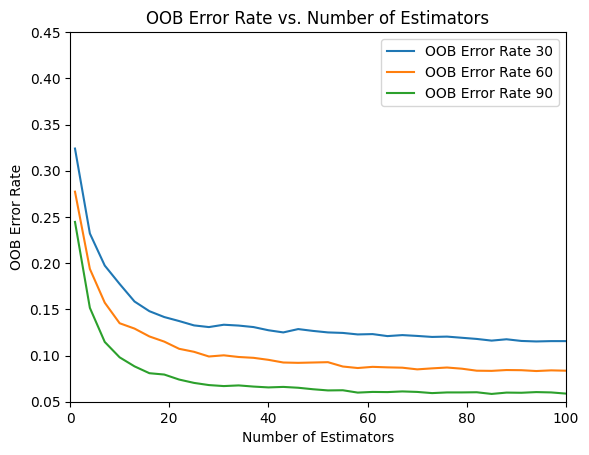

In [133]:
# Plotting Fig 2

# Create target variable (1 for gain, 0 for loss)
AAPL['Increase30'] = (AAPL['smooth'] > AAPL['smooth'].shift(-30)).astype(int)
AAPL['Increase60'] = (AAPL['smooth'] > AAPL['smooth'].shift(-60)).astype(int)
AAPL['Increase90'] = (AAPL['smooth'] > AAPL['smooth'].shift(-90)).astype(int)
AAPL = AAPL.iloc[:-90]

# Define features and target variable
features = ["RSI", "PROC", "SO", "WR", "OBV", "MACD", "High", "Low", "Volume"]
target = 'Increase30'

# Split the data into training and testing sets based on time
train_size = int(len(AAPL) * 0.8)
train, test = AAPL[:train_size], AAPL[train_size:]


# Initialize a dictionary to store the OOB error rates
error_rate30 = OrderedDict()

# Train Random Forest models with different n_estimators and record the OOB error rate
min_estimators = 1
max_estimators = 100
days = [30, 60,90]

# Create a figure and axis
fig, ax = plt.subplots()


for day in days:
    target = f'Increase{day}'
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    for n in range(min_estimators, max_estimators + 1, 3):
        model = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42, warm_start=True)
        model.fit(X_train, y_train)
        oob_error = 1 - model.oob_score_
        error_rate30[n] = oob_error

    ax.plot(list(error_rate30.keys()), list(error_rate30.values()), label=f'OOB Error Rate {day}')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('OOB Error Rate')
ax.set_title('OOB Error Rate vs. Number of Estimators')
# Set x-axis limits
ax.set_ylim([0.05, 0.45])
ax.set_xlim([0, 100])

# Show the plot
plt.show()


# Replicating the Table 2. OOB error Specific results

In [134]:
# Replicatin table 2
num_trees = [5, 25, 45, 65]
days = [30, 60, 90]

#prepareing for the column
trading_period = []
num = []
sample_size = []
OOB_errors = []

# running loop for each day interval
for day in days:

    # preparing for training set and testing set
    target = f'Increase{day}'
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # running for loop for each number of estimators
    for tree in num_trees:
          model = RandomForestClassifier(n_estimators=tree, oob_score=True, random_state=42, warm_start=True)
          model.fit(X_train, y_train)

          # calculating oob_erro rate
          oob_error = 1 - model.oob_score_

          # updating Table 2
          trading_period.append(day)
          num.append(tree)
          sample_size.append(len(train))
          OOB_errors.append(oob_error)

data = {'Trading_Period': trading_period, 'Num_Trees': num, 'Sample_Size': sample_size, 'OOB_Error': OOB_errors}
df = pd.DataFrame(data)

df

,Trading_Period,Num_Trees,Sample_Size,OOB_Error
0,30,5,5528,0.217438
1,30,25,5528,0.132598
2,30,45,5528,0.127894
3,30,65,5528,0.121382
4,60,5,5528,0.179269
5,60,25,5528,0.104016
6,60,45,5528,0.091172
7,60,65,5528,0.087735
8,90,5,5528,0.135311
9,90,25,5528,0.070369


# Replicating Fig 3 APPLE stock: ROC curve

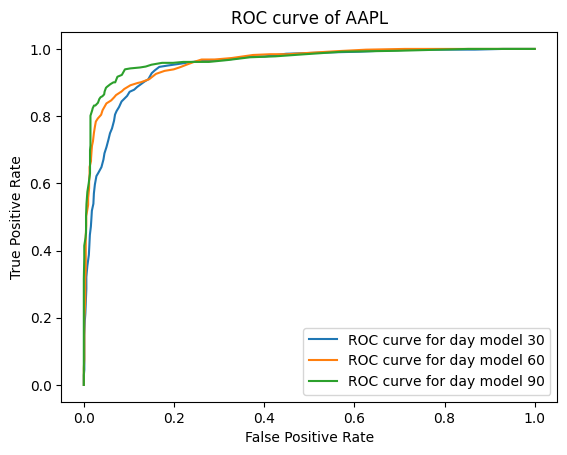

In [136]:
# plotting Figure 3 following paper method
days = [30, 60, 90]

# Create a figure and axis
fig, ax = plt.subplots()

for day in days:
    target = f'Increase{day}'
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(AAPL[features], AAPL[target], test_size=0.2)

    # Train a Random Forest model
    model = RandomForestClassifier(n_estimators=65, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f'ROC curve for day model {day}')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of AAPL')

# Show the plot
plt.show()

# Part 3: plotting Figure 3 using different validation method

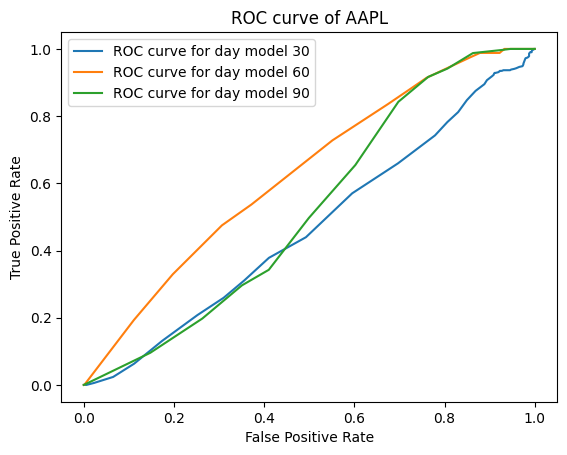

In [137]:
# Plotting Fig 3 considering Time Series Character
days = [30, 60, 90]

# Create a figure and axis
fig, ax = plt.subplots()

for day in days:
    target = f'Increase{day}'
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    # Train a Random Forest model
    model = RandomForestClassifier(n_estimators=65, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f'ROC curve for day model {day}')

# Add a legend
ax.legend()

# Add labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve of AAPL')

# Show the plot
plt.show()

# Extra: Checking Performance of other methods with same features

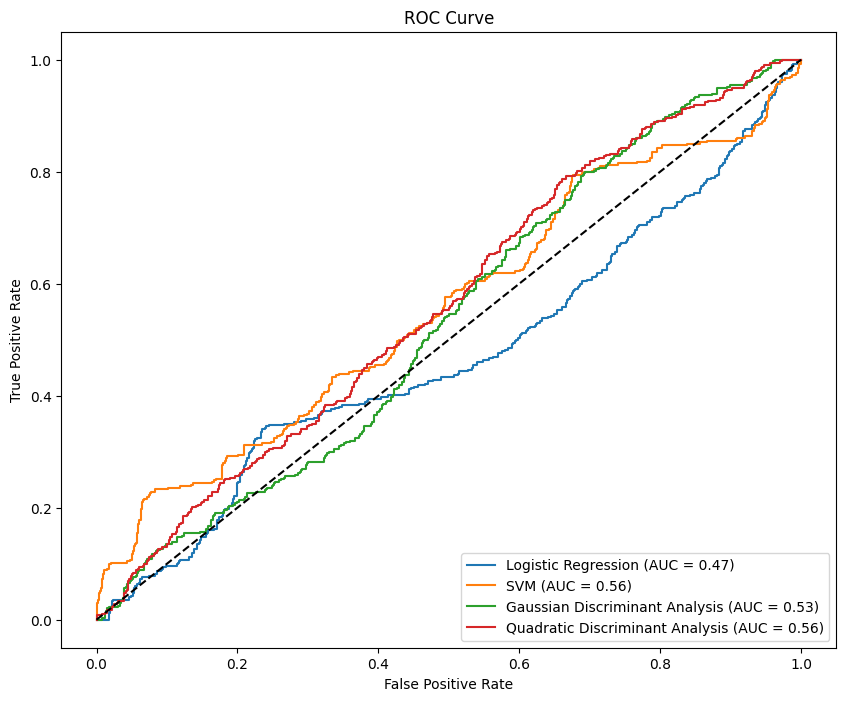

In [138]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

AAPL= AAPL.dropna()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(AAPL[features], AAPL[target], test_size=0.2)
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(probability=True),
    'Gaussian Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis()
}

# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
